##Library Import

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 34.0 MB/s 


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import shap

import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from matplotlib import rcParams
rcParams['figure.figsize'] = 14,8

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data Preprocessing

In [ ]:
sensor_id = 'ssd_05500B'

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/UTS/Hass-DSI/Device Data/Device Data (Updated)/{sensor_id}.csv', index_col=0)

In [ ]:
df['ts'] = pd.to_datetime(df['ts'], format='%Y/%m/%d %H:%M')
df = df.resample('30T', on='ts').agg({'p':'median','t':'median','h':'median','als':'median','uv':'median','voc':'median','pm1':'median','pm25':'median','pm10':'median','People Count':'median'})
df.reset_index(inplace=True)
#df['Hour'] = pd.DatetimeIndex(df['ts']).hour.astype(int)
df.drop(['ts','uv'],axis=1,inplace=True)

for i in df.columns:
    median = int(df[i].median(skipna = True))
    df[i] = df[i].replace(np.NaN, median)

#x = list()

#for i in range(0,len(df)):
  #if 6 <= df['Hour'].iloc[i] < 18:
    #x.append(0)
  #else:
    #x.append(1)

#df['AC Status'] = x

In [ ]:
#df = df[df['AC Status'] == 0]
#df.drop(['AC Status'],axis=1,inplace=True)

###Set Target Variable

In [ ]:
targetVariable = 'People Count'

Data = df.drop(columns = targetVariable)
#for i in Data.columns:
  #Data[i]=(Data[i]-Data[i].mean())/Data[i].std()

Data = Data.values

ds = df.drop(columns = targetVariable)
target = df[targetVariable].values
Data = preprocessing.StandardScaler().fit_transform(Data)

In [ ]:
df.describe()

,p,t,h,als,voc,pm1,pm25,pm10,People Count
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,1013.620140,23.062567,39.291444,47.657096,1.424463,0.067231,0.143501,0.218787,4.224064
std,9.164261,1.230799,6.683810,6.029692,0.976669,0.528487,0.773000,0.861109,6.025092
min,985.293000,20.929000,21.606429,7.727273,0.500000,0.000000,0.000000,0.000000,0.000000
25%,1007.676667,22.179091,35.087692,47.000000,0.776429,0.000000,0.000000,0.000000,0.000000
50%,1015.169231,22.667333,39.875556,49.000000,1.074286,0.000000,0.000000,0.024286,0.000000
75%,1020.917273,23.859286,44.176154,50.000000,1.760000,0.000000,0.027000,0.114615,7.000000
max,1028.600714,26.626154,53.590000,103.000000,7.098000,10.432143,15.043571,16.181429,39.000000


###Feature Ranking Function

In [ ]:
def featureRank(name='Decision Tree',model=DecisionTreeRegressor(),scoring_metric=('neg_root_mean_squared_error','neg_mean_absolute_percentage_error','r2','neg_mean_absolute_error'),num_features=9, cv=5):
  
  cv_results_full = cross_validate(estimator=model, X=Data, y=target, cv=cv, scoring=scoring_metric)

  rmse_test = -cv_results_full['test_neg_root_mean_squared_error'].mean().round(3)
  mape_test = -cv_results_full['test_neg_mean_absolute_percentage_error'].mean().round(3)
  r2_test = cv_results_full['test_r2'].mean().round(3)
  mae_test = -cv_results_full['test_neg_mean_absolute_error'].mean().round(3)
  print('RMSE: ' + str(rmse_test))
  print('MAPE: ' + str(mape_test))
  print('MAE: ' + str(mae_test))
  print('R2: ' + str(r2_test))

  model = model.fit(Data, target)

  predicted = cross_val_predict(model, Data, target, cv=5)

  fig, ax = plt.subplots()
  ax.scatter(target, predicted, edgecolors=(0, 0, 0))
  ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

  try:
    indices_model = np.argsort(np.nan_to_num(model.coef_))[::-1][0:num_features]
    plot_imp(ds.columns[indices_model].values, model.coef_[indices_model], name)

    shap.initjs()
    explainer = shap.Explainer(model,Data)
    shap_values = explainer.shap_values(Data)
    shap.summary_plot(shap_values, features=Data, feature_names=df.drop(columns = targetVariable).columns)
  
  except:
    indices_model = np.argsort(np.nan_to_num(model.feature_importances_))[::-1][0:num_features]
    plot_imp(ds.columns[indices_model].values, model.feature_importances_[indices_model], name)


    shap.initjs()
    explainer = shap.Explainer(model,Data,check_additivity=False)
    shap_values = explainer.shap_values(Data,check_additivity=False)
    shap.summary_plot(shap_values, features=Data, feature_names=df.drop(columns = targetVariable).columns)

  return (rmse_test,mape_test,r2_test,mae_test,name)

In [ ]:
di = pd.DataFrame({'RMSE':[],'MAPE':[],'MAE':[],'R2':[],'Model':[]})

##Modelling (Hyperparameter Tuning, Cross-Validation and Feature Ranking)

###Decision Tree Regressor

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'criterion': 'squared_error', 'max_depth': 128, 'min_samples_leaf': 64, 'min_samples_split': 8, 'splitter': 'random'}
RMSE: 5.735
MAPE: 9160305988780958.0
MAE: 4.381
R2: 0.029


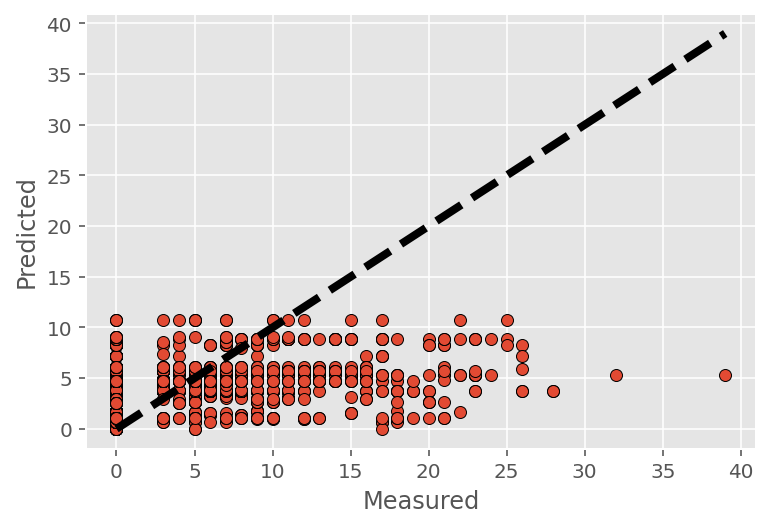

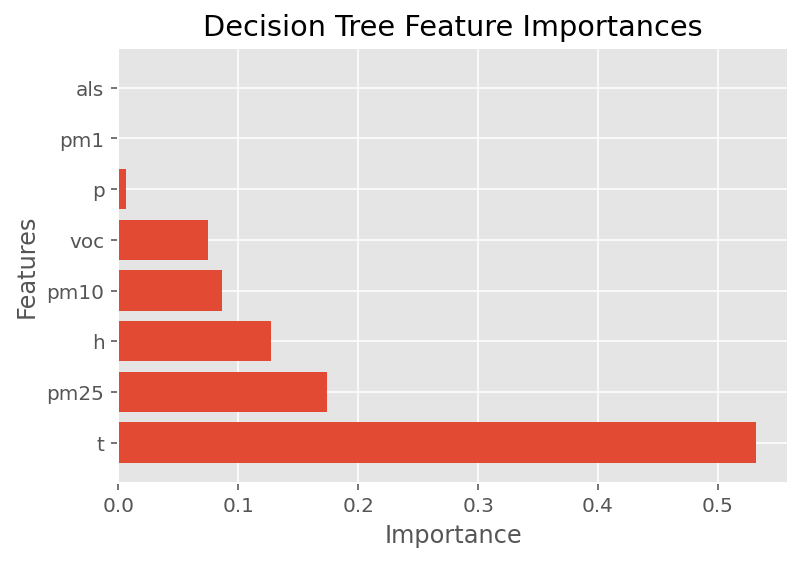

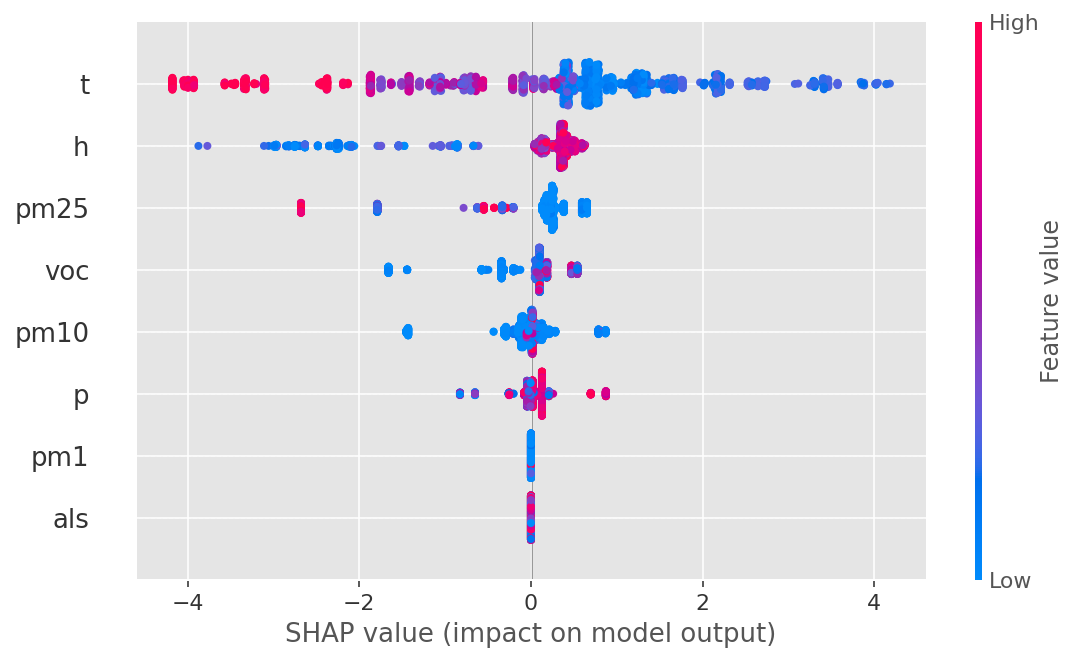

In [ ]:
name = 'Decision Tree'
model = DecisionTreeRegressor()

param_grid = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
              'splitter':['best','random'],
              'max_depth':[8,32,64,128],
              'min_samples_split':[8,32,64,128],
              'min_samples_leaf':[8,32,64,128]}

search = GridSearchCV(model, param_grid, cv=5,scoring='r2',verbose=1)
search.fit(Data,target)

print(search.best_params_)
#print(search.best_score_)


rmse_test,mape_test,r2_test,mae_test,name = featureRank(name=name,model=DecisionTreeRegressor(
  criterion = search.best_params_['criterion'],
  splitter = search.best_params_['splitter'],
  max_depth = search.best_params_['max_depth'],
  min_samples_split = search.best_params_['min_samples_split'],
  min_samples_leaf = search.best_params_['min_samples_leaf']))

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

###Random Forest Regressor

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 32}
RMSE: 5.876
MAPE: 8778007052807789.0
MAE: 4.346
R2: -0.052


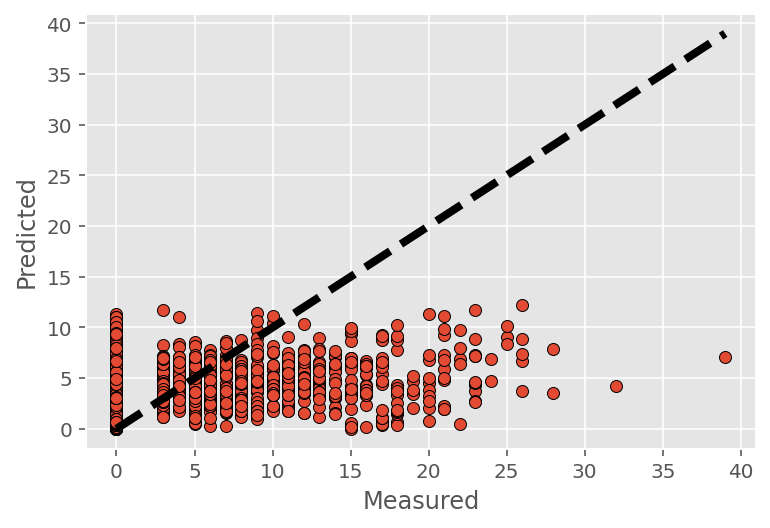

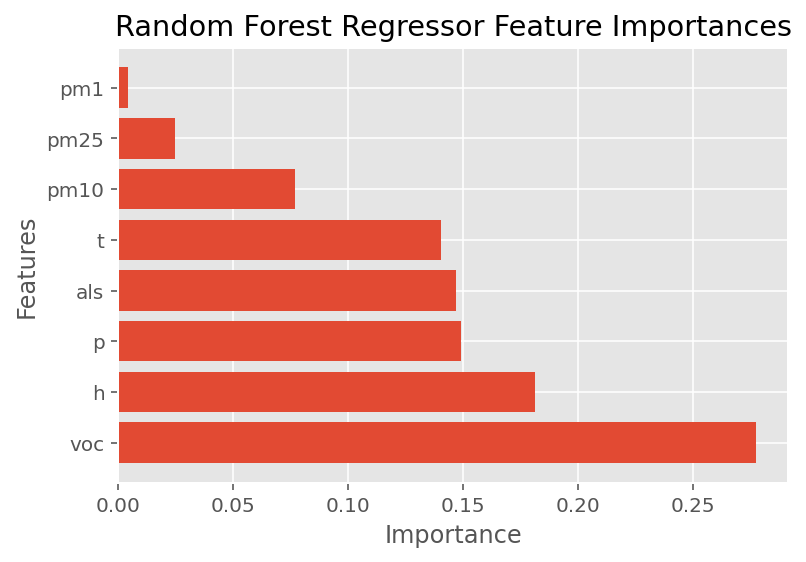

 97%|=================== | 1587/1629 [00:27<00:00]       

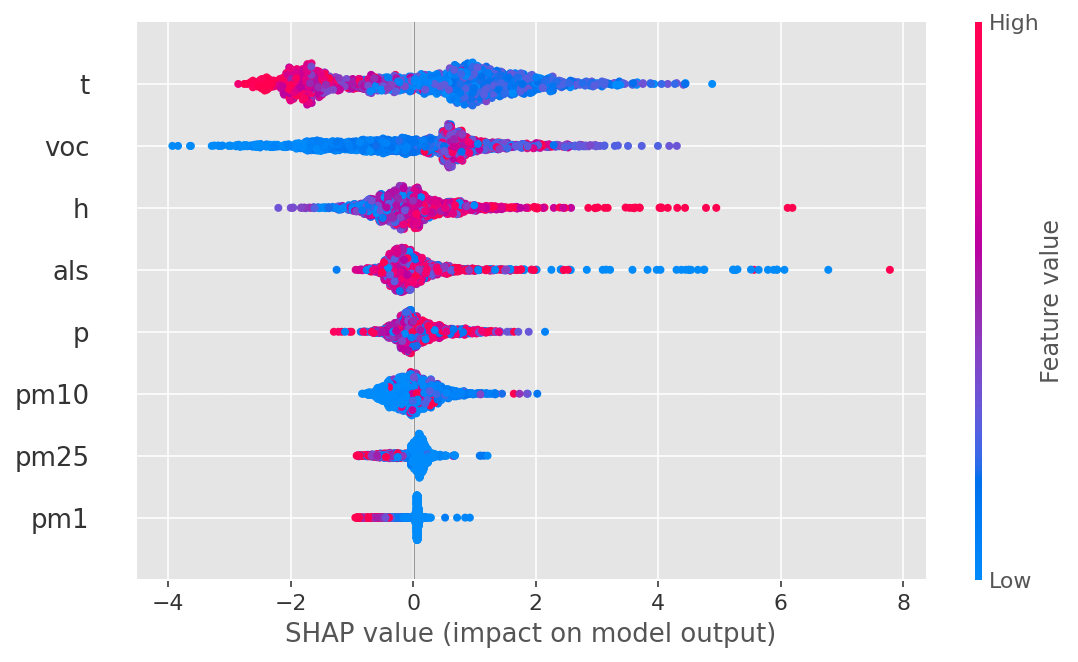

In [ ]:
name = 'Random Forest Regressor'
model = RandomForestRegressor()

param_grid = {'criterion':['squared_error','absolute_error','poisson'],
              'bootstrap':[True,False],
              'max_depth':[2,8,32]}

search = GridSearchCV(model, param_grid, cv=5,scoring='r2',verbose=1)
search.fit(Data,target)

print(search.best_params_)
#print(search.best_score_)

rmse_test,mape_test,r2_test,mae_test,name = featureRank(name=name,model=RandomForestRegressor(
  criterion = search.best_params_['criterion'],
  bootstrap= search.best_params_['bootstrap'],
  max_depth= search.best_params_['max_depth']))

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

###XGBoost Regressor

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[22:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:07] WARNING: /workspace/src/objective/reg

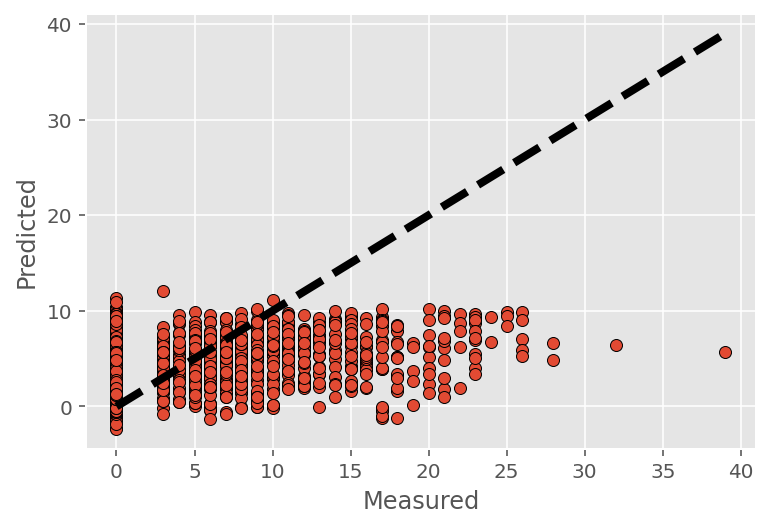

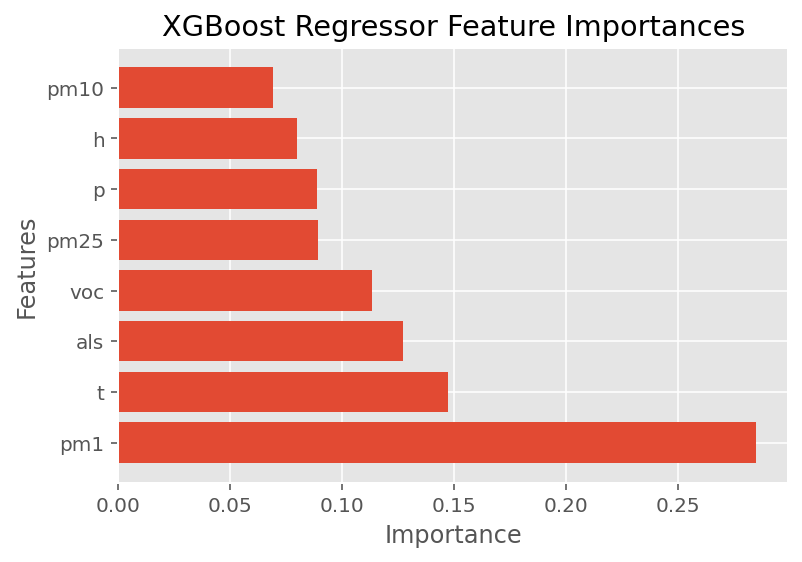

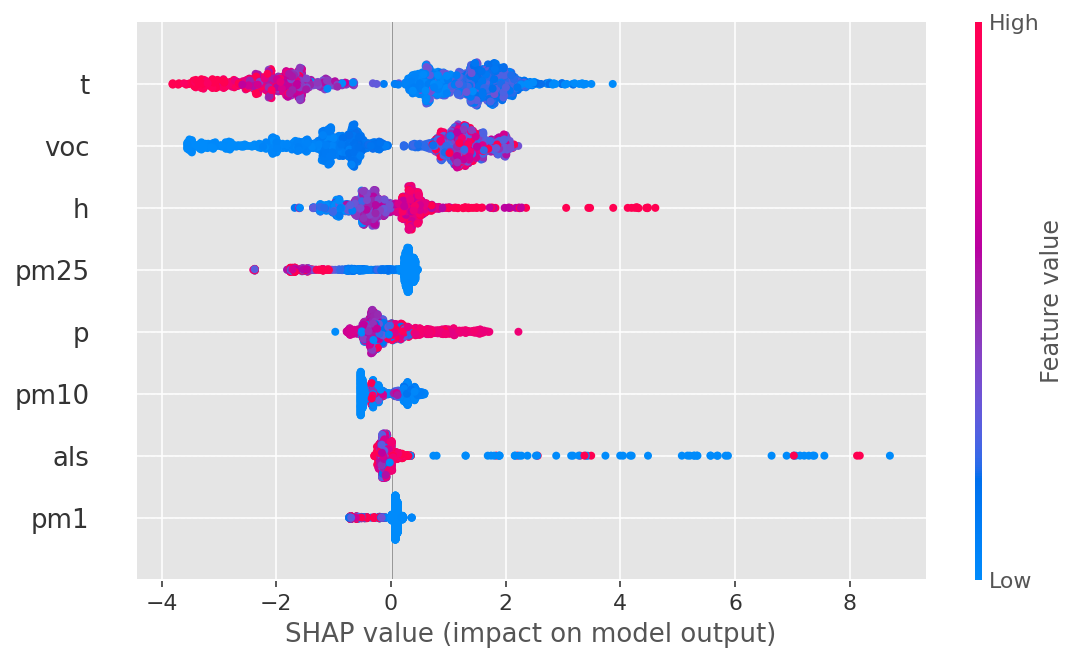

In [ ]:
name = 'XGBoost Regressor'
model = XGBRegressor()

param_grid = {'eta':[0.0001,0.001,0.01],
              'gamma':[0,2,8],
              'max_depth':[3,12],
              'alpha':[0,1,4],
              'max_delta_step':[0,2,8]}

search = GridSearchCV(model, param_grid, cv=5,scoring='r2',verbose=1)
search.fit(Data,target)

print(search.best_params_)

rmse_test,mape_test,r2_test,mae_test,name = featureRank(name=name,model=XGBRegressor(
  eta = search.best_params_['eta'],
  gamma = search.best_params_['gamma'],
  max_depth = search.best_params_['max_depth'],
  alpha = search.best_params_['alpha'],
  max_delta_step = search.best_params_['max_delta_step']    
))

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

###Linear Regressor

RMSE: 5.867
MAPE: 1.0462377033024854e+16
MAE: 4.531
R2: -0.02


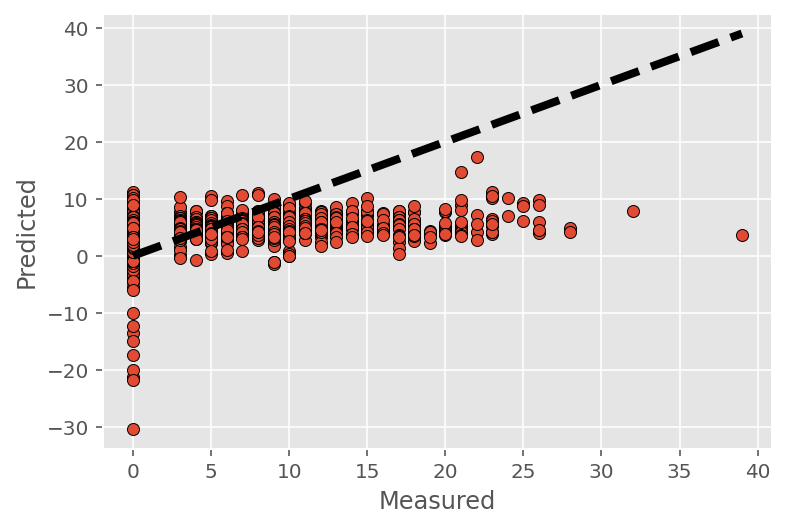

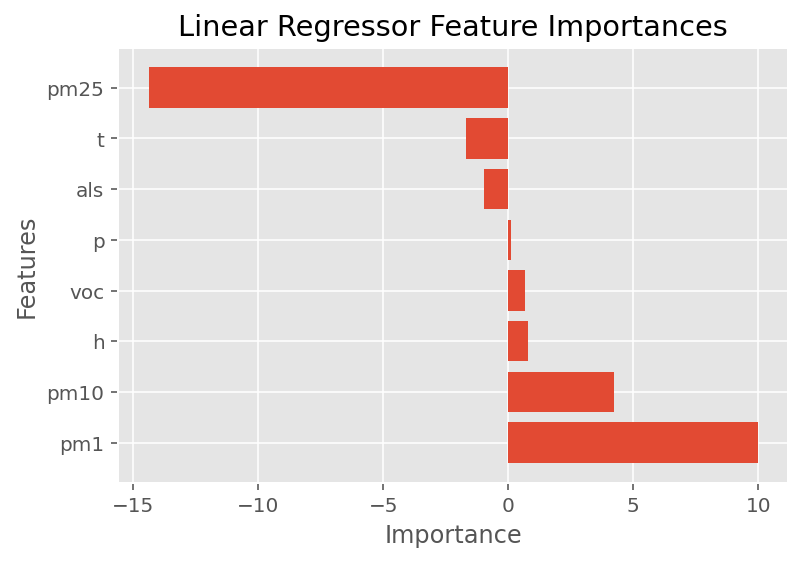

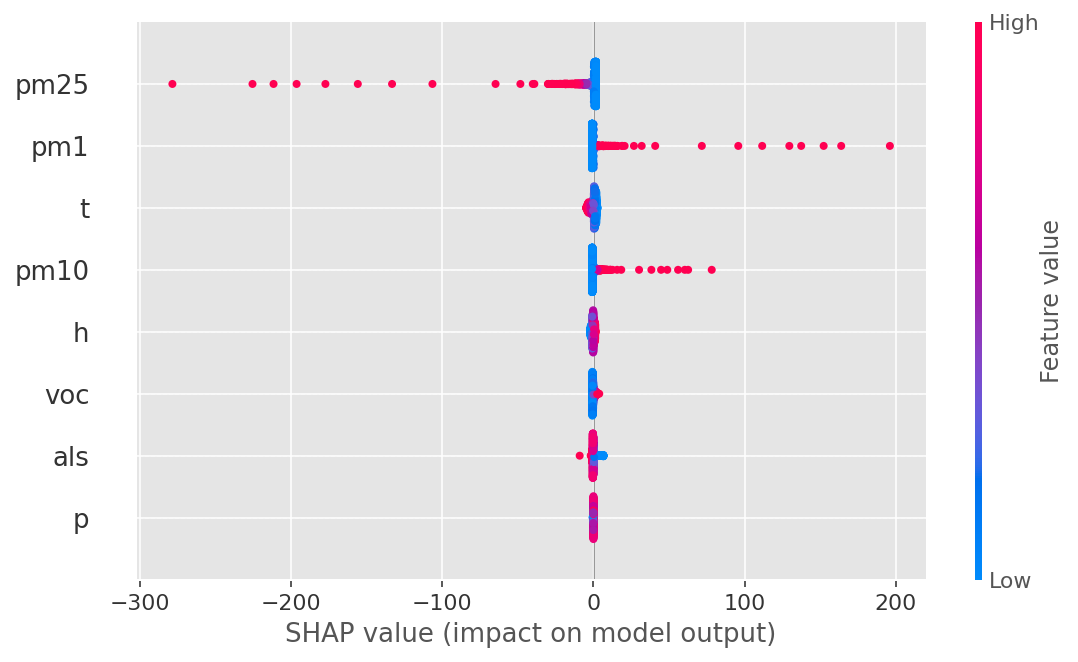

In [ ]:
name = 'Linear Regressor'
model = LinearRegression()

param_grid = {}

#search = GridSearchCV(model, param_grid, cv=5,scoring='neg_mean_absolute_percentage_error',verbose=1)
#search.fit(Data,target)

#print(search.best_params_)

rmse_test,mape_test,r2_test,mae_test,name = featureRank(name=name,model=LinearRegression())

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

###Stochastic Gradient Descent

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence.

{'alpha': 0.01, 'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': True}
RMSE: 6.324
MAPE: 1.0814047482641022e+16
MAE: 4.648
R2: -0.238


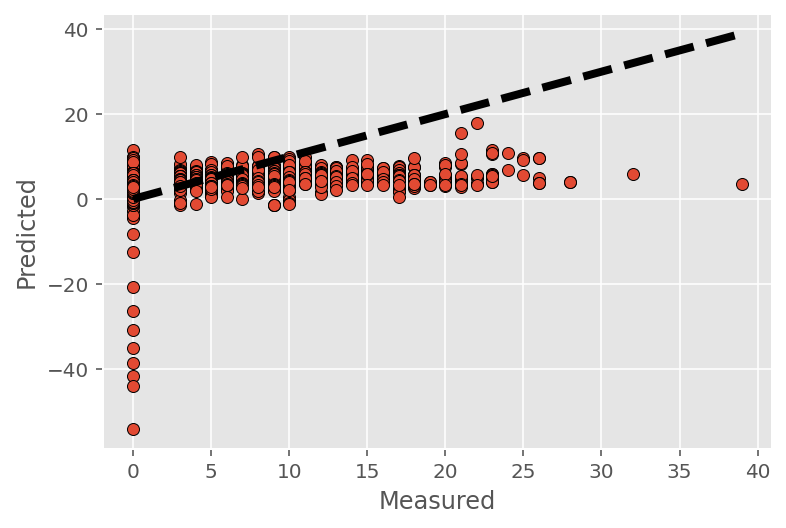

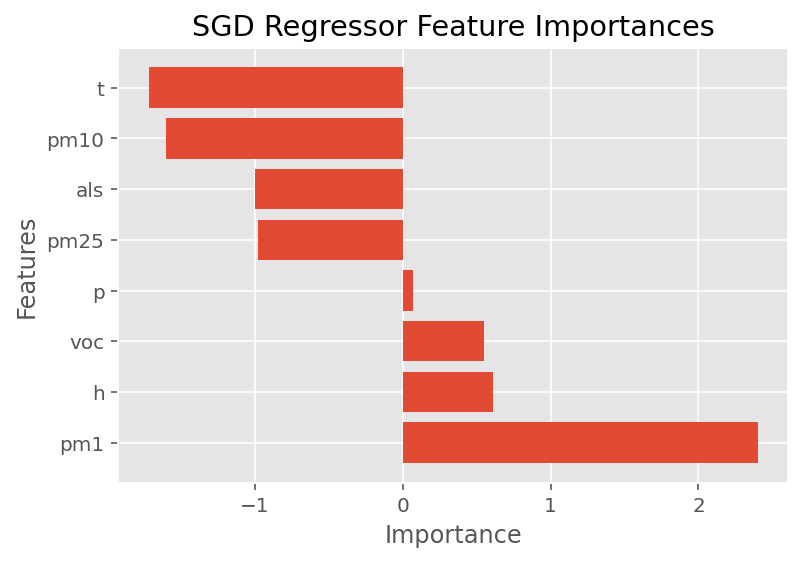

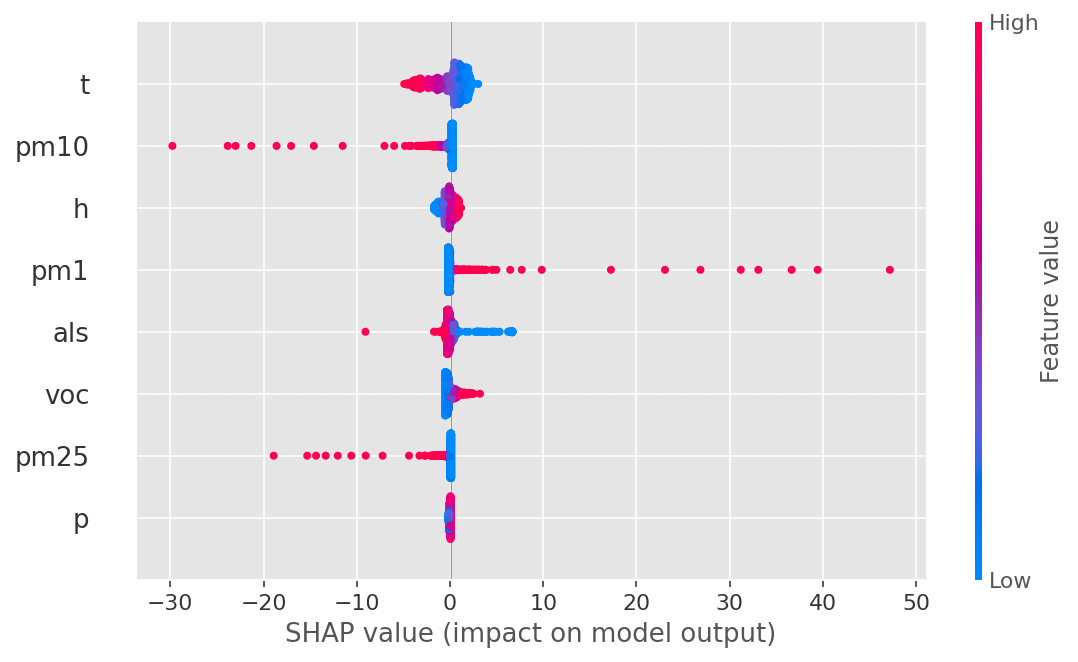

In [ ]:
name = 'SGD Regressor'
model = SGDRegressor()

param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'alpha':[0.0001,0.001,0.01],
              'max_iter':[100,500,1000],
              'learning_rate':['constant','optimal','invscaling','adaptive'],
              'shuffle':[True,False]}

search = GridSearchCV(model, param_grid, cv=5,scoring='r2',verbose=1)
search.fit(Data,target)

print(search.best_params_)

rmse_test,mape_test,r2_test,mae_test,name = featureRank(name='SGD Regressor',model=SGDRegressor(
  penalty = search.best_params_['penalty'],
  alpha = search.best_params_['alpha'],
  max_iter = search.best_params_['max_iter'],
  learning_rate = search.best_params_['learning_rate'],
  shuffle = search.best_params_['shuffle']   
))

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

###Gradient Boosting Regressor

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'alpha': 0.2, 'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 32, 'n_estimators': 100, 'subsample': 0.2}
RMSE: 6.325
MAPE: 1.1678357837561972e+16
MAE: 4.902
R2: -0.244


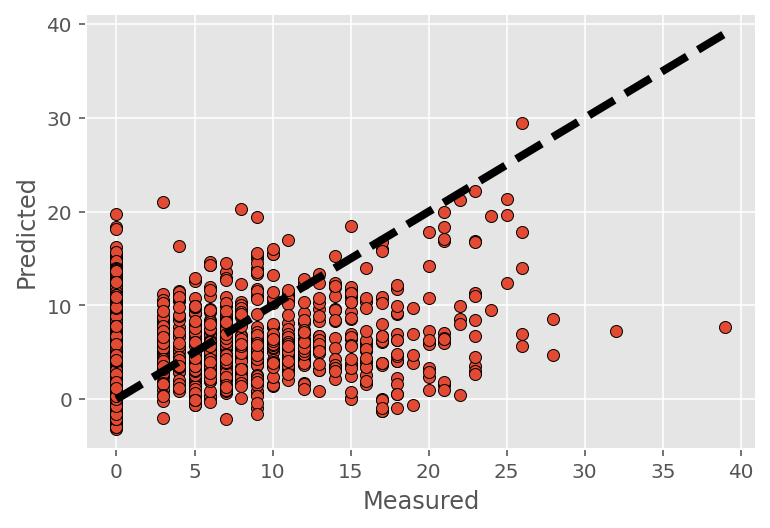

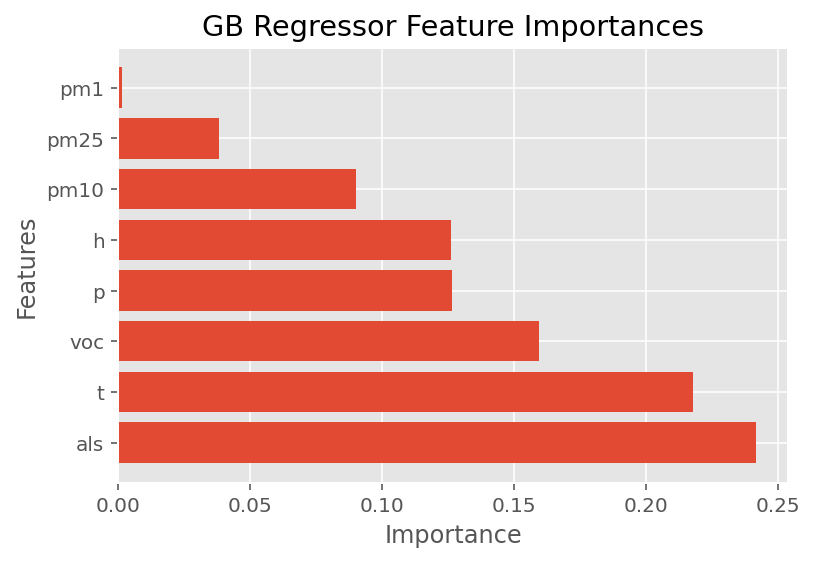

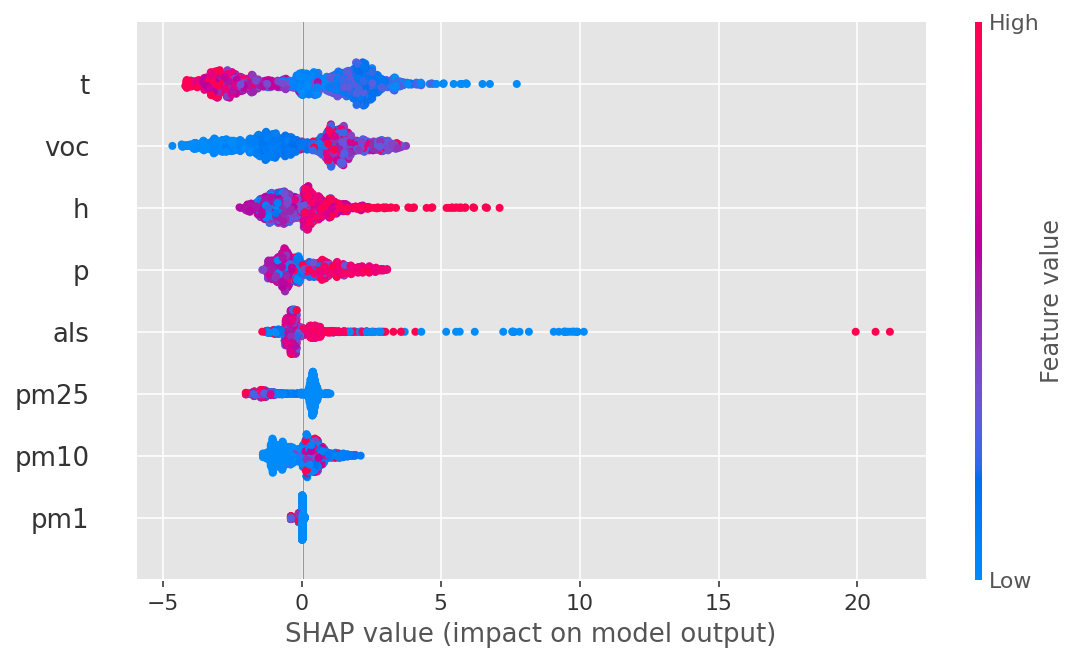

In [ ]:
name = 'GB Regressor'
model = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,200],
              'subsample':[0.2,0.5,1],
              'criterion':['friedman_mse', 'squared_error'],
              'min_samples_split':[2,8,32],
              'max_depth':[3,9,18],
              'alpha':[0.2,0.9]}

search = GridSearchCV(model, param_grid, cv=5,scoring='r2',verbose=1)
search.fit(Data,target)

print(search.best_params_)

rmse_test,mape_test,r2_test,mae_test,name = featureRank(name=name,model=GradientBoostingRegressor(
  alpha = search.best_params_['alpha'],
  criterion = search.best_params_['criterion'],
  max_depth = search.best_params_['max_depth'],
  min_samples_split = search.best_params_['min_samples_split'],
  n_estimators = search.best_params_['n_estimators'],
  subsample = search.best_params_['subsample']      
))

In [ ]:
di = di.append({'RMSE':rmse_test,'MAPE':mape_test,'MAE':mae_test,'R2':r2_test,'Model':name},ignore_index=True)

##Evaluation Metrics

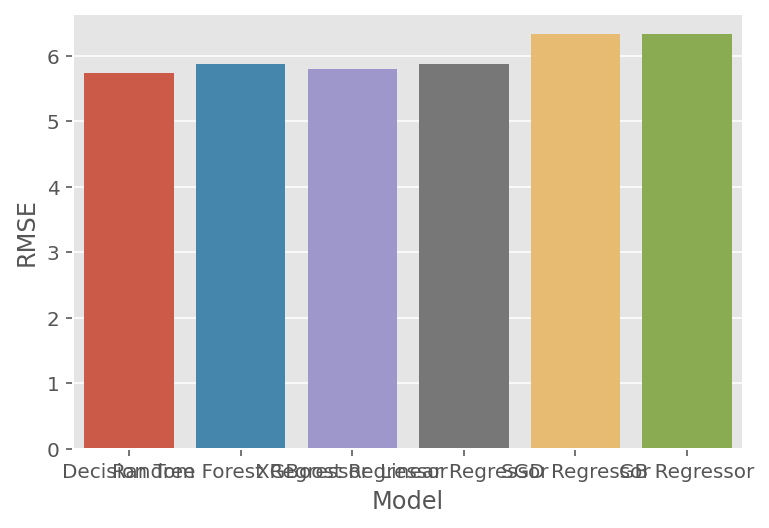

In [ ]:
sns.barplot(data=di,x='Model',y='RMSE')

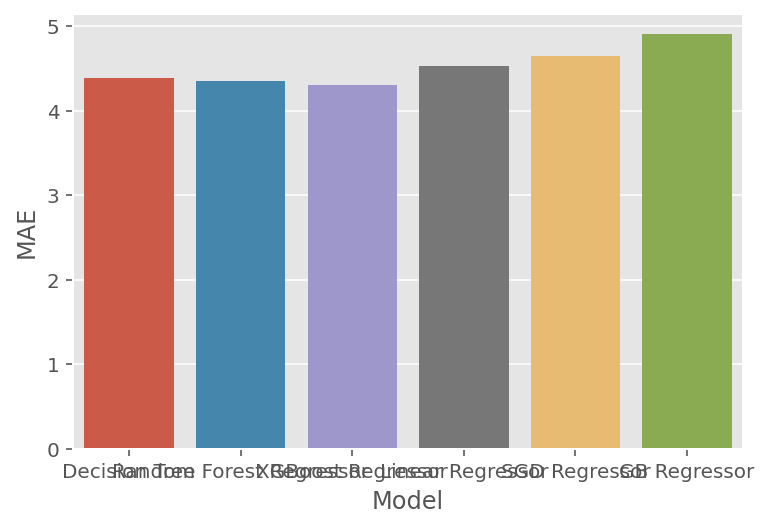

In [ ]:
sns.barplot(data=di,x='Model',y='MAE')

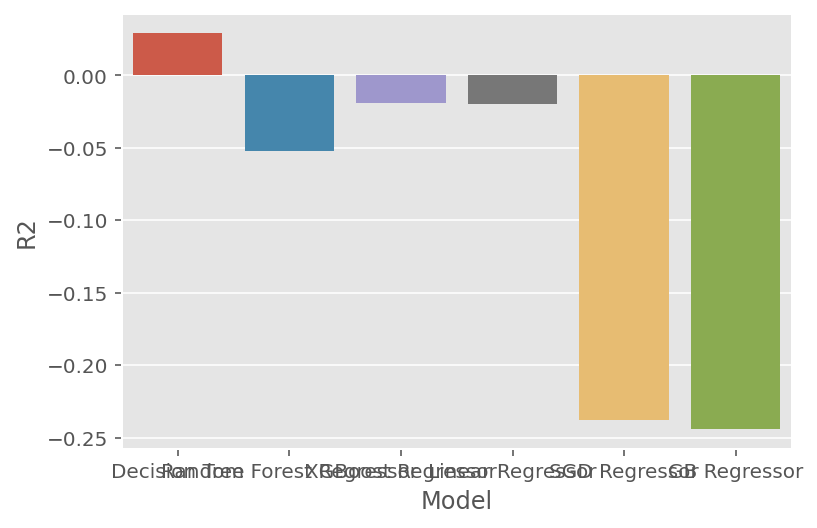

In [ ]:
sns.barplot(data=di,x='Model',y='R2')